
# Clustering text documents using k-means


This is an example showing how the ```scikit-learn``` package can be used to perform clustering and classification. In this notebook, we consider the case of document clustering. Doing this, we will review:
1. How a document is converted into a vector of features. In particular, we consider tf-idf vectorization.
2. How k-means clustering can be applied to perform unsupervised clustering of the documents.
3. How this is done in practice using the ```scikit-learn``` package.

The case of document clustering is one in which we have a highly dimensional space (the vectors representing documents belong to a space whose dimensions are in the tens of thousands). As we will see, dimensionality reduction can mitigate the "curse of dimensionality" in cases like this, by denoising data and improving performance of euclidean-based clustering approaches. 

Before proceeding we need to hava NLTK, which we use to extract features from the documents. In a nutshell, each feature will correspond to a word, or [lemma](https://simple.wikipedia.org/wiki/Lemma_(linguistics)) to be more precise.

## Installing NLTK
[NLTK](https://www.nltk.org/index.html) stands for "Natural Language ToolKit". It is a python package that allows to perform natural language analysis. In particular, we use it to i) extract words from documents and ii) to extract [lemmas](https://simple.wikipedia.org/wiki/Lemma_(linguistics)). These will correspond to the components of the tf-idf vectors corresponding to the documents.
Installing NLTK is easy (you should have python 3 (>= 3.4)).
1. [Install NLTK](http://www.nltk.org/install.html#)
2. [Install NLTK Data](http://www.nltk.org/data.html). This is done from within the python shell and will import (among others) corpora that are used to perform tokenization, lemmatization etc. 

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Datasets
To test our ideas, we begin with some standard datasets, for which ```sklearn``` provides a class for automatic downloading and preprocessing. 
As stated in the description, "The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based on messages being posted before or after a specific date." Please refer to http://scikit-learn.org/stable/datasets/index.html#the-20-newsgroups-text-dataset for more information.

To begin with, we import the libraries we will be using in this notebook:

In [8]:
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize #Used to extract words from documents
from nltk.stem import WordNetLemmatizer #Used to lemmatize words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans

import sys
from time import time

import numpy as np

```TfidfVectorizer``` is used to convert a collection of documents, represented as a list of strings, into the corresponding tf-idf matrix. 

We first select some categories from the 20 newsgroups dataset. These are specified by a list of string descriptors:

In [9]:
categories = [
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]

print("Loading 20 newsgroups dataset for categories:")
print(categories)

Loading 20 newsgroups dataset for categories:
['talk.religion.misc', 'comp.graphics', 'sci.space']


We next download the corresponding dataset:

In [10]:
dataset = fetch_20newsgroups(subset='all', categories=categories, 
                             shuffle=False, remove=('headers', 'footers', 'quotes'))

Here, ```subset='all'``` means the dataset is downloaded in its entirety and is not split into a training and test set, which we do not need in this case. Documents are not randomly reordered (```Shuffle=False```) and we remove all metadata, leaving only body text. ```dataset``` is an object describing the dataset. Its attributes ```filenames``` and ```target``` are two arrays, respectively containing the paths to the different documents and the corresponding labels, represented as integers from ```0``` to ```len(categories) - 1```.

In [11]:
labels = dataset.target
true_k = len(np.unique(labels)) ## This should be 3 in this example 

We first perform lemmatization. We can skip this block, since TfidfVectorizer also performs tokenization and feature extraction.

In [12]:
lemmatizer = WordNetLemmatizer()
for i in range(len(dataset.data)):
    word_list = word_tokenize(dataset.data[i])
    lemmatized_doc = ""
    for word in word_list:
        lemmatized_doc = lemmatized_doc + " " + lemmatizer.lemmatize(word)
    dataset.data[i] = lemmatized_doc  

In [13]:
print(dataset.data[1])

 In regard to fractal commpression , I have seen 2 fractal compressed `` movie '' . They were both fairly impressive . The first one wa a 64 gray scale `` movie '' of Casablanca , it wa 1.3MB and had 11 minute of 13 fps video . It wa a little grainy but not bad at all . The second one I saw wa only 3 minute but it had 8 bit color with 10fps and measured in at 1.2MB . I consider the fractal movie a practical thing to explore . But unlike many other format out there , you do end up losing resolution . I do n't know what kind of software/hardware wa used for creating the `` movie '' I saw but the guy that showed them to me said it took 5-15 minute per frame to generate . But a I said above playback wa 10 or more frame per second . And how else could you put 11 minute on one floppy disk ?


We next convert our corpus into tf-idf vectors. We remove common stop words, terms with very low document frequency (many of them are numbers or misspells), accents. 

In [14]:
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', min_df=2) ## Corpus is in English
X = vectorizer.fit_transform(dataset.data)

In [15]:
print(X.shape)

(2588, 14439)


## Clustering take 1: using standard k-means
We first cluster documents using the standard k-means algorithm (actually, a refined variant called k-means++), without any further date preprocessing. The key parameter of choice when performing k-means is $k$. Alas, there really is no principled way to choose an initial value for $k$. Essentially we have two options:

1. We choose a value that reflects our knowledge about the data, as in this case
2. We try several value, possibly in increasing order. We proceed this way as long as the quality of the resulting clustering (as measured by one or more quality indices) increases. We stop when it starts decreasing. As you may suspect, this case arises pretty often in practice

In this specific case, we set $k = 3$ of course

In [16]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))

done in 1.100s


We next take some standard measure of cluster quality. Please refer to ```sklearn.metrics``` documentation for details.

In [17]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Homogeneity: 0.393
Completeness: 0.464
V-measure: 0.426
Adjusted Rand-Index: 0.336
Silhouette Coefficient: 0.008


In a nutshell, the above results are saying that we achieve some decent degree of clustering, but this is not optimal, at least according to standard measures of clustering quality. In particular, there is a certain degree of overlap among different cluster, with many pairs of documents from the same category assigned to different partitions

We next identify the 10 most relevant terms in each cluster. Intuitively, these are the ones that correspond to entries of largest magnitude in the centroids

In [18]:
centroids = km.cluster_centers_.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: god jesus wa christian bible people did say koresh word
Cluster 1: file image thanks format know program graphic ftp graphics color
Cluster 2: wa space just like think ha time year nasa orbit


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Visualizing results
Finally, we build a word cloud of the most important terms for each cluster. For the $i$-th cluster, the importance of every term is measured by the magnitude of the corresponding component in the $i$-th centroid  

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [20]:
def frequencies_dict(cluster_index):
    if cluster_index > true_k - 1:
        return
    term_frequencies = km.cluster_centers_[cluster_index]
    sorted_terms = centroids[cluster_index]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_terms}
    return frequencies

In [21]:
def makeImage(frequencies):

    wc = WordCloud(background_color="white", max_words=50)
    # generate word cloud
    wc.generate_from_frequencies(frequencies)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

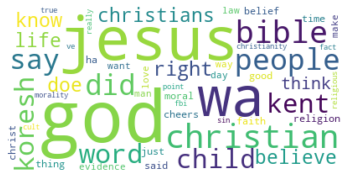

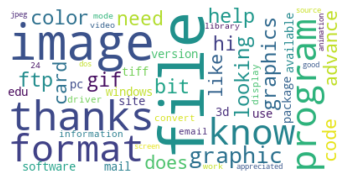

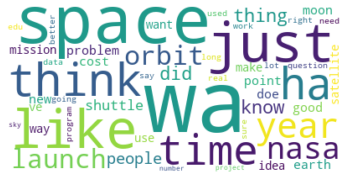

In [22]:
for i in range(true_k):
    freq = frequencies_dict(i)
    makeImage(freq)
    print()